In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
sns.set()

In [2]:
#Build NA covid data for all airport comparisons
# Build total + new NA cases
NaData = pd.read_csv("Archieved-Data/casesNA.csv", compression = 'gzip')
NaData["Date"] = pd.to_datetime(NaData["Date"])
NaSums = NaData.groupby(NaData['Date']).sum().reset_index()
naCases = NaSums[['Date','Confirmed']]
temp = naCases.shift(1)
naCases['New'] = naCases['Confirmed'] - temp['Confirmed']
naCases.loc[0,"New"] = 0
new_cases_smooth = lowess(naCases['New'], naCases["Date"], frac =0.05)
confirm_smooth = lowess(naCases['Confirmed'], naCases["Date"], frac =0.05)
naCases['New_smooth'] = new_cases_smooth[:,1]
naCases['Confirm_smooth'] = confirm_smooth[:,1]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [3]:
yul = pd.read_csv('yul4analyze_both.csv',index_col =0, parse_dates = [1])
yulCases = pd.read_csv('Covid-Data/yul-modified.csv', index_col =0, parse_dates = [5])

yul["Date"] = pd.to_datetime(yul["Date"])
yulCases["Date"] = pd.to_datetime(yulCases["Date"])

yulCases.loc[0, "Difference"] = 0

In [4]:
# Well thats a funky looking plot.
"""plt.figure(figsize = (20,5))
plt.plot(yul["Date"], yul['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yulCases["Date"], yulCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yulCases["Date"], yulCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()"""

'plt.figure(figsize = (20,5))\nplt.plot(yul["Date"], yul[\'PercentOfBaseline\'], \'b-\', label = \'Percentage Baseline\')\nplt.plot(yulCases["Date"], yulCases[\'Difference\'], \'r-\', label = \'Difference in Cases\', alpha = 0.4)\n#plt.plot(yulCases["Date"], yulCases[\'Confirmed\'], \'m-\', label = \'Difference in Cases\', alpha = 0.4)\nplt.xlabel("Mid-March to Mid October")\nplt.legend()\nplt.show()'

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


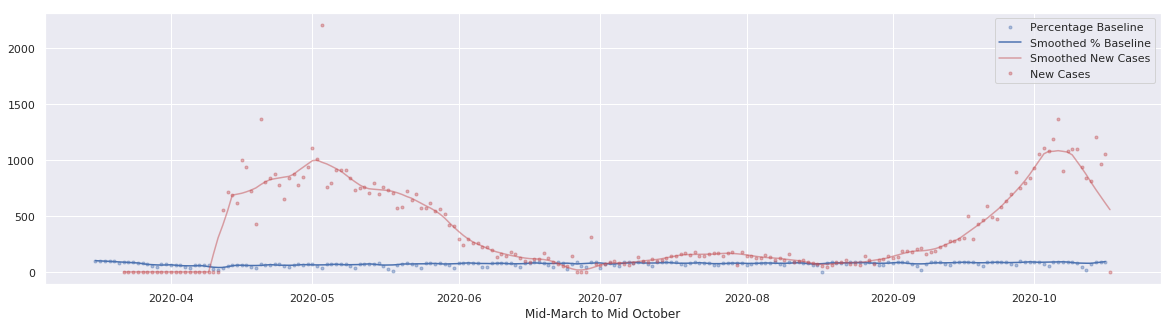

In [5]:
# baseline seems constant; except for the small dip in March
# Find factors to attribute to the two curves - small bump in the summer?
# The second one might be an instance to not increase flights to YUL
# lots of 0s in the beginning.... averaging or imputing the missing values might have been a good idea

new_cases_smooth = lowess(yulCases['Difference'], yulCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yul['PercentOfBaseline'], yul["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yulCases['Diff_smooth'] = new_cases_smooth[:,1]
yul['Baseline_smooth'] = baseline_smooth[:,1]
# Ensure both yul and yulCases start and end on the same dates
if (yul.count().loc['Date'] != yulCases.count().loc['Date']):
    joined = yulCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yul[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yulCases["Diff_smooth"]
    y = yul["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yul["Date"], yul['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yul["Date"], yul['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yulCases["Date"], yulCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yulCases["Date"], yulCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

-0.10402831009506948


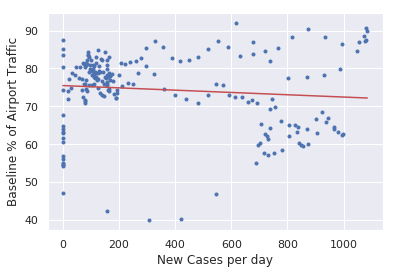

In [6]:
# Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above

plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

linearX = np.linspace(0, max(X)) 
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')

# neglible correlation. so assume none at all - look into possible factors
# are people still travelling, or not travelling?

0.7736308232381547


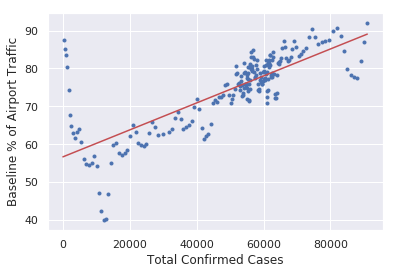

In [7]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0, max(confirmX)) 
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')

# this is pretty interesting - strong indication of positive correlation

0.03161060592601043
-0.8346080940000261


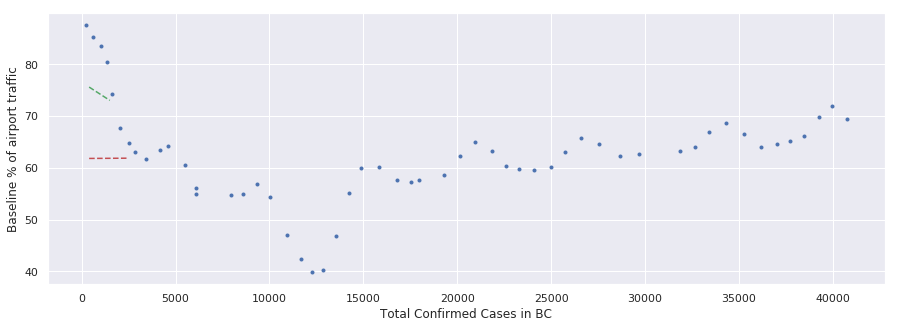

In [8]:
# Analyzing statistical correlation in --> full first wave
first_wave = joined[joined['Date']<'2020-05-15']
plt.figure(figsize = (15,5))

"""plt.plot(first_wave["Date"], first_wave['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.7)
plt.plot(first_wave["Date"], first_wave['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(first_wave["Date"], first_wave["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(first_wave["Date"], first_wave['Difference'], 'r.', label = 'New Cases', alpha = 0.7)
plt.xlabel("Mid-March to Mid-May: First Wave")
plt.legend()
plt.show() #two things over time"""

plt.plot(first_wave["Confirmed"],first_wave["Baseline_smooth"], 'b.')
plt.xlabel("Total Confirmed Cases in BC")
plt.ylabel("Baseline % of airport traffic")

regression = stats.linregress(first_wave["Confirmed"], first_wave["Baseline_smooth"])
print(regression.rvalue)

linearX = np.linspace(400,2400)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r--')

# We can clearly see that while there was a huge decrease in airport traffic in the 
# beginning, but it recovered over time back to the new normal
# how about when we try to only look at the first 25 days? 
reg2 = stats.linregress(first_wave["Confirmed"].head(25), first_wave["Baseline_smooth"].head(25))
print(reg2.rvalue)
lin2 = np.linspace(400,1500)
plt.plot(lin2, reg2.slope*lin2+ reg2.intercept,'g--')
# get rvalue showing there is indeed a close linear correlation in the first 'shock'
# but later on, no longer the same correlation